# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** YOUR ID HERE ***

In [904]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [905]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [911]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

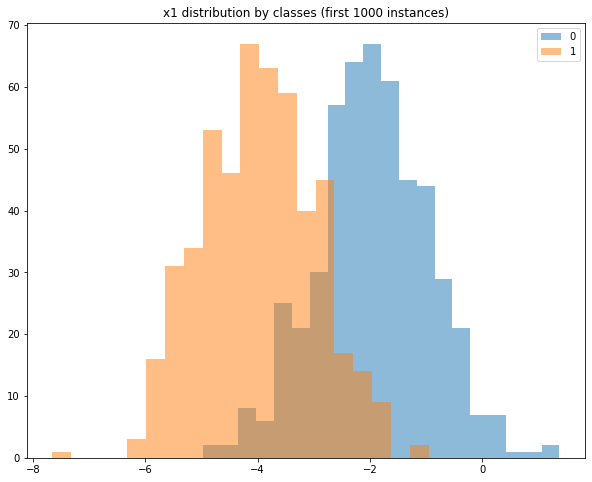

In [912]:
first_feature_data_1000 = np.column_stack((X_training[:1000,0], y_training[:1000]))
zero_class_data_1000 = first_feature_data_1000[np.where(first_feature_data_1000[:,1] == 0)]
one_class_data_1000 = first_feature_data_1000[np.where(first_feature_data_1000[:,1] == 1)]

kwargs_1 = dict(histtype='stepfilled', alpha=0.5, bins=20)
plt.title("x1 distribution by classes (first 1000 instances)")
plt.hist(zero_class_data_1000[:,0], **kwargs_1, label="0")
plt.hist(one_class_data_1000[:,0], **kwargs_1, label="1")
plt.legend()
plt.show()

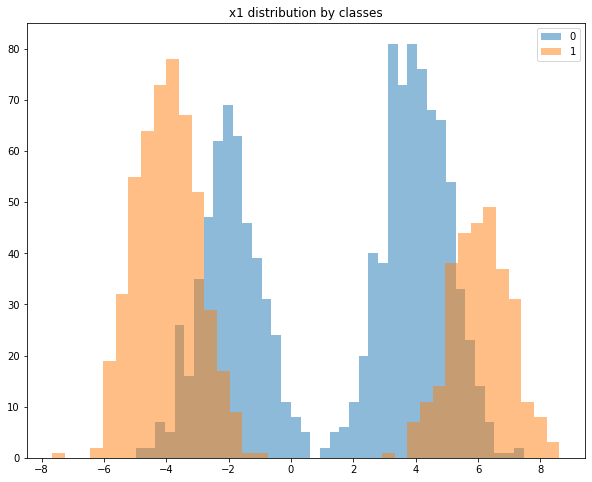

In [914]:
first_feature_data = np.column_stack((X_training[:,0], y_training))
zero_class_data = first_feature_data[np.where(first_feature_data[:,1] == 0)]
one_class_data = first_feature_data[np.where(first_feature_data[:,1] == 1)]

kwargs_2 = dict(histtype='stepfilled', alpha=0.5, bins=40)
plt.title("x1 distribution by classes")
plt.hist(zero_class_data[:,0], **kwargs_2, label="0")
plt.hist(one_class_data[:,0], **kwargs_2, label="1")
plt.legend()
plt.show()

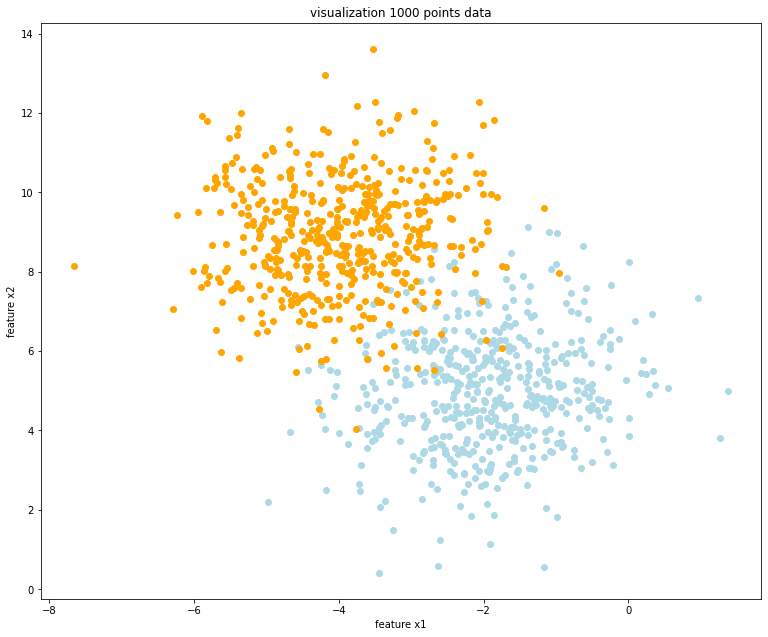

In [915]:
data_1000 = np.column_stack((X_training[:1000], y_training[:1000]))
zero_calss_1000 = data_1000[np.where(data_1000[:,-1] == 0)]
one_calss_1000 = data_1000[np.where(data_1000[:,-1] == 1)]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(zero_calss_1000[:,0], zero_calss_1000[:,1], color='lightblue')
ax.scatter(one_calss_1000[:,0], one_calss_1000[:,1], color='orange')
ax.set_xlabel('feature x1')
ax.set_ylabel('feature x2')
ax.set_title('visualization 1000 points data')
plt.show()

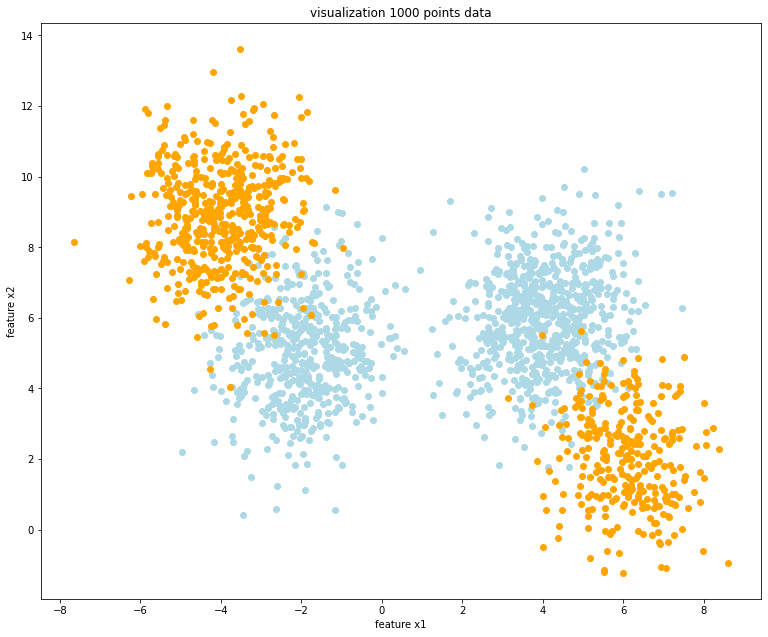

In [916]:
data_1000 = np.column_stack((X_training, y_training))
zero_calss_1000 = data_1000[np.where(data_1000[:,-1] == 0)]
one_calss_1000 = data_1000[np.where(data_1000[:,-1] == 1)]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(zero_calss_1000[:,0], zero_calss_1000[:,1], color='lightblue')
ax.scatter(one_calss_1000[:,0], one_calss_1000[:,1], color='orange')
ax.set_xlabel('feature x1')
ax.set_ylabel('feature x2')
ax.set_title('visualization 1000 points data')
plt.show()

## Logistic Regression

(20 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [379]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        np.random.seed(random_state)
        self.theta = np.random.permutation(X_training.shape[1])
        self.costs = []
        self.eta = eta
        self.eps = eps
        self.n_iter = n_iter
        self.classification_threshold = 0.5
        
    def calc_sigmoid(self, X, theta):
        return (1 / (1 + np.exp(-np.dot(X, theta)))) + self.eps
        
    def calc_cost(self, X, y, theta):
        m = X.shape[0]
        h = self.calc_sigmoid(X=X, theta=theta)
        J = (1 / m) * np.sum(np.matmul(-y, np.log(h)) - np.matmul((1 - y), np.log(1 - h)))
        return J
    
    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        for i in range(self.n_iter):
            self.costs.append(self.calc_cost(X, y, self.theta))
            h = self.calc_sigmoid(X=X, theta=self.theta)
            self.theta = self.theta - self.eta * np.sum(np.dot(h - y, X))
            if i > 0 and self.costs[i] - self.costs[i - 1] <= self.eps: 
                break
        
    def predict(self, X):
        """
        Return the predicted class label
        """
        h = self.calc_sigmoid(X, self.theta)
        return [0 if h[i] < self.classification_threshold else 1 for i in range(X.shape[0])]

    def calc_accuracy(self, predicted_y, real_y):
        if len(predicted_y) != len(real_y):
            return 0
        num_of_success = 0
        for i in range(len(real_y)):
            if predicted_y[i] == real_y[i]: 
                num_of_success += 1
        return num_of_success / len(real_y)

## Cross Validation

(10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [382]:
def find_best_params(X, y, eta_list, eps_list):
    # for each couple eta,eps: 
    # fit model and calc cross validation (average cost)
    validation_info = []
    for eta in eta_list:
        for eps in eps_list:
            average = calc_cost_by_cross_validation(X, y, eta, eps)
            validation_info.append(dict({ "eta": eta, "eps": eps, "accuracy": average }))
    sorted_accuracies = sorted(validation_info, key=lambda x: x["accuracy"], reverse=True)
    optimal_params = sorted_accuracies[0]
#     for i in range(len(sorted_accuracies)):
#         print(sorted_accuracies[i]["accuracy"])
    return optimal_params["eta"], optimal_params["eps"]

def calc_cost_by_cross_validation(X, y, eta, eps, k=5):
    s_X, s_y = shuffle_data(X, y)
    Xs, ys = split_data_to_folds(s_X, s_y, k)
    accuracies = []
    for i in range(len(Xs)):
        training_X, training_y = np.zeros((0, 2)), np.zeros((0))
        for j in range(len(Xs)):
            if (j == i):
                validation_X, validation_y = Xs[j], ys[j]
            else:
                training_X = np.append(training_X, Xs[j], axis=0)
                training_y = np.append(training_y, ys[j], axis=0)
        LoR = LogisticRegressionGD(eps=eps, eta=eta)
        LoR.fit(training_X, training_y)
        predicted_y = LoR.predict(validation_X)
        accuracy = LoR.calc_accuracy(predicted_y, validation_y)
        accuracies.append(accuracy)
    average = np.mean(accuracies)
    return average

def shuffle_data(X, y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], y[randomize]

def split_data_to_folds(X, y, k):
    return np.array_split(X, k), np.array_split(y, k)

In [383]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [384]:
optimal_eta, optimal_eps = find_best_params(X_training, y_training, etas, epss)
print(optimal_eta, optimal_eps)

0.0005 0.0001


## Normal distribution pdf

(5 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [739]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    power_of_e = -0.5 * (((data - mu) / sigma) ** 2)
    scalar = 1 / np.dot((np.sqrt(2 * np.pi)), sigma)
    return (scalar * np.exp(power_of_e))

## Expectation Maximization

(20 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [795]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.w = np.zeros(self.k)
        self.mu = np.zeros(self.k)
        self.sigma = np.zeros(self.k)
        self.responsibilities = np.array([]) 
        
    # initial guesses for parameters
    def init_params(self, data, random_state=1):
        """
        Initialize distribution params
        """   
        for i in range(self.k):
            self.w[i] = (1 / self.k)
            self.mu[i] = np.mean(data)
            self.sigma[i] = np.std(data)
            
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """ 
        ###Evaluate the responsibilities of each data point to each Gaussian using the current parameters
        responsibilities_matrix = np.zeros((len(data), self.k))
        probabilities = []
        for i in range(len(data)):
            for j in range(self.k):
                responsibilities_matrix[i][j] = self.w[j] * norm_pdf(data[i], self.mu[j], self.sigma[j])
            probabilities.append(responsibilities_matrix[i].sum())
            
        for i in range(len(data)):
            for j in range(self.k):
                responsibilities_matrix[i][j] /= probabilities[i]
                
        return responsibilities_matrix
    
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        sum_per_gaussian = self.responsibilities.sum(axis=0)
        m = len(data)
        for i in range(self.k):
            self.w[i] = (1.0 / m) * sum_per_gaussian[i]
            self.mu[i] = (1 / (self.w[i] * m)) * np.sum((np.dot(data, self.responsibilities[:, i])))
            self.sigma[i] = np.sqrt((1 / (self.w[i] * m)) * np.sum(np.dot(self.responsibilities[:, i], np.square(data - self.mu[i]))))
            
    def calc_cost(self, data):
        costs = np.zeros((len(data), self.k))
        for i in range(len(data)):
            for j in range(self.k):
                costs[i] -= np.log(self.w[j] * norm_pdf(data[i], self.mu[j], self.sigma[j]))
        
        return costs.sum()
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)            
        for i in range(self.n_iter):
            self.responsibilities = self.expectation(data)
            prev_cost = self.calc_cost(data)
            self.maximization(data)
            cur_cost = self.calc_cost(data)
            if abs(cur_cost - prev_cost) <= self.eps:
                break
                
    def get_dist_params(self):
        return self.w , self.mu , self.sigma

In [803]:
feature_data = X_training[:, 0]
em = EM()
em.fit(feature_data)

In [806]:
w, mu, sig = em.get_dist_params()
print(w, mu, sig)

[1.] [0.84460832] [4.05088639]


## Naive Bayes

(20 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [847]:
# I want to find the class that maximaize the postirior --> P(A|x) = argmax(P(Ai) * mult_of_all_d's(P(x_d|Ai)))
# I need to split the data per class and give the EM the data as (x|A) or (x|B)  
# class NaiveBayesGaussian(object):
#     """
#     Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

#     Parameters
#     ------------
#     k : int
#       Number of gaussians in each dimension
#     random_state : int
#       Random number generator seed for random params initialization.
#     """
    
#     def __init__(self, k=1):
#         self.k = k
#         self.params = {
#             "0": { "prior": 0, "weights": [], "features_mus": [], "features_sigmas": [] },
#             "1": { "prior": 0, "weights": [], "features_mus": [], "features_sigmas": [] }
#         }
        
    
#     def calc_priors(self, X, y):
#         zero_data, one_data = self.split_by_class(X, y)
#         self.params["0"]["prior"] = len(zero_data) / len(X)
#         self.params["1"]["prior"] = len(one_data) / len(X)
        
#     def split_by_class(self, X, y):
#         data_with_classes = np.column_stack((X, y))
#         zero_data = data_with_classes[np.where(data_with_classes[:,-1] == 0)]
#         one_data = data_with_classes[np.where(data_with_classes[:,-1] == 1)]
#         print(zero_data, one_data)
#         return zero_data, one_data
        
#     def calc_likelihood(self, instance, label):
#         naive_likelihood = 1
#         for i in range(len(instance)):
#             mus = self.params[label]["features_mus"]
#             sigmas = self.params[label]["features_sigmas"]
#             feature_likelihood = 0
#             for i in range(self.k):
#                 feature_likelihood += self.params[label]["weights"][i] * norm_pdf(instance[i], mus[i], sigmas[i])
#             naive_likelihood *= feature_likelihood
#         return naive_likelihood
        
#     def calc_posterior(self, label):
#         pass
           
#     def fit_by_class(self, data, label):
#         for i in range(data.shape[1] - 1):
#             em = EM(k=self.k)
#             feature_data = data[:, i]
#             em.fit(feature_data)
#             w, mu, sigma = em.get_dist_params()
#             self.params[label]["weights"].append(w)
#             self.params[label]["features_mus"].append(mu)
#             self.params[label]["features_sigmas"].append(sigma)
        
#     def fit(self, X, y):
#         """ 
#         Fit training data.

#         Parameters
#         ----------
#         X : array-like, shape = [n_examples, n_features]
#           Training vectors, where n_examples is the number of examples and
#           n_features is the number of features.
#         y : array-like, shape = [n_examples]
#           Target values.
#         """
#         self.calc_priors(X, y)
#         zero_data, one_data = self.split_by_class(X, y)
#         self.fit_by_class(zero_data, "0")
#         self.fit_by_class(one_data, "1")
#         print("class 0 params:",self.params["0"],"\n")
#         print("class 1 params:",self.params["1"])
            
#     def predict(self, X):
#         """Return the predicted class label"""
#         # calc P(0|x) - likelihood_0_x1 * likelihood_0_x2 * prior_0 
#         # calc P(1|x) - likelihood_1_x1 * likelihood_1_x2 * prior_1
#         # return max
#         pass


In [901]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.data_class_zero = np.array([])
        self.data_class_one = np.array([])
        self.prior_0, self.prior_1 = 0, 0
        self.ws0, self.mus0, self.sigmas0 = [], [], []
        self.ws1, self.mus1, self.sigmas1 = [], [], []
        
    def split_by_class(self, X, y):
        data_with_classes = np.column_stack((X, y))
        self.data_class_zero = data_with_classes[np.where(data_with_classes[:,-1] == 0)]
        self.data_class_one = data_with_classes[np.where(data_with_classes[:,-1] == 1)]

    def calc_priors(self):
        num_of_all_data = (len(self.data_class_zero) + len(self.data_class_one))
        prior_class_zero = len(self.data_class_zero) / num_of_all_data
        prior_class_one = len(self.data_class_one) / num_of_all_data
        return prior_class_zero, prior_class_one
    
     
    def calc_GMM(self, instance_feature, w, mu, sigma):
        prob_instance_feature = 0;
        for i in range(self.k):
            prob_instance_feature += w[i] * norm_pdf(instance_feature, mu[i], sigma[i])
        return prob_instance_feature
        
    
    def calc_likelihood(self, X):
        likelihood_matrix_0 = np.ones(self.data_class_zero.shape)
        likelihood_matrix_1 = np.ones(self.data_class_one.shape)
        for j in range(X.shape[1]):
            for i in range(self.data_class_zero.shape[0]):
                likelihood_matrix_0[i][j] = self.calc_GMM(X[i][j], self.ws0[j], self.mus0[j], self.sigmas0[j])
            for i in range(self.data_class_one.shape[0]):
                likelihood_matrix_1[i][j] = self.calc_GMM(X[i][j], self.ws1[j], self.mus1[j], self.sigmas1[j])
        return likelihood_matrix_0, likelihood_matrix_1
        
    def calc_posterior(self, prior, likelihood_matrix):
        naive_likelihood = np.prod(likelihood_matrix, axis=1)
        return prior * naive_likelihood
           
    def fit_by_class(self, data_given_class, feature_index):
        w, mu, sigma = [], [], []
        em = EM(k=self.k)
        feature_data = data_given_class[:, feature_index]
        em.fit(feature_data)
        w, mu, sigma = em.get_dist_params()
        return w, mu, sigma
    
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.split_by_class(X, y)
        self.prior_0, self.prior_1 = self.calc_priors()
        for j in range(X.shape[1]):
            w0, mu0, sigma0 = self.fit_by_class(self.data_class_zero, j)
            w1, mu1, sigma1 = self.fit_by_class(self.data_class_one, j)
            self.ws0.append(w0)
            self.ws1.append(w1)
            self.mus0.append(mu0)
            self.mus1.append(mu1)
            self.sigmas0.append(sigma0)
            self.sigmas1.append(sigma1)
            
    def predict(self, X):
        """Return the predicted class label"""
        # calc P(0|x) - likelihood_0_x1 * likelihood_0_x2 * prior_0 
        # calc P(1|x) - likelihood_1_x1 * likelihood_1_x2 * prior_1
        # return max
        likelihood_matrix_0, likelihood_matrix_1 = self.calc_likelihood(X)
        print()
        posteriors_0 = self.calc_posterior(prior_0, self.likelihood_matrix_0) 
        posteriors_1 = self.calc_posterior(prior_1, self.likelihood_matrix_1)
        

In [903]:
naive_bayes = NaiveBayesGaussian()
naive_bayes.fit(X_training, y_training)
naive_bayes.predict(X_test)
# naive_bayes.fit(X_training, y_training)
# print(naive_bayes.calc_likelihood(X_training[1,:], "0"))
# print(naive_bayes.calc_likelihood(X_training[1,:], "1"))
# naive_bayes.calc_priors(X_training, y_training)
# naive_bayes

IndexError: index 1000 is out of bounds for axis 0 with size 1000

## Open question

(7 points) 

Will Full Bayes get better results comparing to Naive Bayes on the following dataset? Explain. 

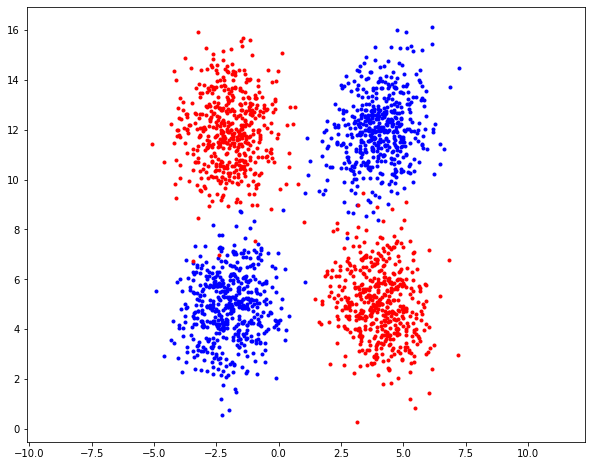

In [89]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']
for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])
plt.axis('equal')
plt.show()

#### Your answer here ####
